# Исследование убытков развлекательного приложения

## Оглавление

1. [Введение](#intro)
2. [Открытие и подготовка данных](#data)
    1. [Открытие данных ](#open)
    2. [Обработка названий столбцов](#columns)
    3. [Изменение типов данных](#types)
    4. [Обработка пропусков](#nulls)
    5. [Обработка дубликатов](#duplicates)
3. [Подготовка функций для расчета и анализа бизнес-показателей](#functions)
4. [Исследовательский анализ данных](#analysis)
    1. [Составление профилей пользователей](#profiles)
    2. [Анализ стран пользователей](#countries)
    3. [Анализ устройств пользователей](#devices)
    4. [Анализ рекламных источников](#channels)
5. [Анализ маркетинга](#marketing)
    1. [Вычисление суммы всех расходов](#costs)
    2. [Анализ расходов на рекламные источники](#costs_by_channels)
    3. [Анализ динамики изменения расходов](#costs_history)
    4. [Анализ средней стоимости привлечения пользователей](#cac)
6. [Оценка окупаемости рекламы](#roi)
    1. [Анализ общей окупаемости рекламы](#roi_total)
    2. [Анализ конверсии пользователей](#conversion)
    3. [Анализ удержания пользователей](#retention)
    4. [Анализ окупаемости рекламы с разбивкой по устройствам](#roi_by_devices)
    5. [Анализ окупаемости рекламы с разбивкой по странам](#roi_by_countries)
    6. [Анализ окупаемости рекламы с разбивкой по рекламным источникам](#roi_by_channels)
7. [Общий вывод](#total)
8. [Проблемы и рекомендации для бизнеса](#recommendations)

## Введение <a id="intro">

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания, выпустившая развлекательное приложение, терпит убытки. 

Задача для отдела маркетинговой аналитики:
- Разобраться в причинах и помочь компании выйти в плюс.

Имеются данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- Лог сервера с данными об их посещениях,
- Выгрузка их покупок за этот период,
- Рекламные расходы.

Требуется изучить:
- Откуда приходят пользователи и какими устройствами они пользуются?
- Сколько стоит привлечение пользователей из различных рекламных каналов?
- Сколько денег приносит каждый клиент?
- Когда расходы на привлечение клиента окупаются?
- Какие факторы мешают привлечению клиентов?

## Открытие и подготовка данных <a id="data">

### Открытие данных <a id="open">

Загрузим необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Откроем файл с данными.

In [2]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

Выведем первые 5 строк из датасетов.

In [3]:
display(visits.head())
display(orders.head())
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Обработка названий столбцов <a id="columns">

Для удобства работы со столбцами стоит привести их названия к нижнему регистру, а также заменить пробелы на нижнее подчеркивание.

In [4]:
def rename_columns(data):
    '''
    функция принимает: датасет
    функция возвращает: датасет с измененными названиями столбцов (нижний регистр и замена пробелов)
    '''
    return data.columns.str.lower().str.replace(' ', '_')

visits.columns = rename_columns(visits)
orders.columns = rename_columns(orders)
costs.columns = rename_columns(costs)

### Изменение типов данных <a id="types">

Проверим, какие типы данных есть в датасетах.

In [5]:
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Поменяем тип данных у столбцов с датами на `datetime`. Столбцу `dt` в тратах на рекламные источники зададим формат даты.

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Типы данных в остальных столбцах не требуют изменений.

### Обработка пропусков <a id="nulls">

Посмотрим, какой процент пропущенных значений во всех столбцах датасетов.

In [7]:
def display_null(data):
    '''
    функция принимает: датасет
    функция выводит: проценты пропущенных значений в каждом столбце датасета
    '''
    display(data.isnull().sum()*100/len(data))

display_null(visits)
display_null(orders)
display_null(costs)

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

dt         0.0
channel    0.0
costs      0.0
dtype: float64

Пропусков в данных нет.

### Обработка дубликатов <a id="duplicates">

Проверим, если в датасетах явные дубликаты.

In [8]:
def print_duplicates(data):
    '''
    функция принимает: датасет
    функция выводит: количество явных дубликатов в датасете
    '''
    print(data.duplicated().sum())

print_duplicates(visits)
print_duplicates(orders)
print_duplicates(costs)

0
0
0


Явных дубликатов в данных нет.

## Подготовка функций для расчета и анализа бизнес-показателей <a id="functions">

Зададим функцию для создания профилей пользователей с САС.

In [9]:
def get_profiles(sessions, orders, ad_costs):
    '''
    функция принимает: данные по сессиям, заказам, тратам на рекламу
    функция возвращает: профили пользователей и САС
    '''
    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    # время первого посещения назовём first_ts
    # сбрасываем индексы, чтобы убрать user_id из индекса
    profiles = sessions.sort_values(by=['user_id', 'session_start']).groupby('user_id').agg(
        {
            'session_start': 'first',
            'channel': 'first',
            'device': 'first',
            'region': 'first',
        }
    ).rename(columns={'session_start': 'first_ts'}).reset_index()  

    # для когортного анализа определяем дату первого посещения и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    # столбец с числом пользователей назовём unique_users
    # сбрасываем индексы
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(
        columns={'user_id': 'unique_users'}
    ).reset_index()

    # объединяем траты на рекламу и число привлечённых пользователей по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе, поэтому в столбце acquisition_cost у них NaN
    # заменим их на ноль, тк стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    # возвращаем профили с CAC
    return profiles  

Зададим функцию для подсчета Retention Rate (удержание пользователей).

In [10]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''
    функция принимает: данные по профилям и сессиям, момент и горизонт анализа, список признаков, 
    игнорировать ли пользователей, не доживших до горизонта анализа
    функция возвращает: сырые данные для расчета удержания, таблицы удержания и динамики удержания
    '''
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        '''
        функция принимает: датасет с сырыми данными, список признаков, горизонт анализа
        функция возвращает: таблица удержания, сгруппированная по желаемым признакам
        '''
        # строим «треугольную» таблицу удержания
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # вычисляем размеры когорт
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(
            columns={'user_id': 'cohort_size'}
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты и получаем retention rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Зададим функцию для подсчета конверсии.

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''
    функция принимает: данные по профилям и покупкам, момент и горизонт анализа, список признаков,
    игнорировать ли пользователей, не доживших до горизонта анализа
    функция возвращает: сырые данные для расчета конверсии, таблица конверсии и динамики конверсии
    '''
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = purchases.sort_values(
        by=['user_id', 'event_dt']
    ).groupby('user_id').agg({'event_dt': 'first'}).reset_index()

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        '''
        функция принимает: датасет с сырыми данными, список признаков, горизонт анализа
        функция возвращает: таблица конверсии, сгруппированная по желаемым признакам
        '''
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(
            columns={'user_id': 'cohort_size'}
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Зададим функцию для подсчета LTV и ROI.

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''
    функция принимает: данные по профилям и покупкам, момент и горизонт анализа, список признаков,
    игнорировать ли пользователей, не доживших до горизонта анализа
    функция возвращает: сырые данные для расчетов, таблица LTV и динамики LTV, таблица ROI и динамики ROI
    '''
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        '''
        функция принимает: датасет с сырыми данными, список признаков, горизонт анализа
        функция возвращает: таблицы LTV и ROI, сгруппированные по желаемым признакам
        '''
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(
            columns={'user_id': 'cohort_size'}
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(
            columns={'acquisition_cost': 'cac'}
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC и ROI
        # в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Зададим функцию для сглаживания данных скользящим средним.

In [13]:
def filter_data(df, window):
    '''
    функция принимает: датасет и ширина окна сглаживания
    функция возвращает: датасет после сглаживания данных скользящим средним
    '''
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Зададим функцию для построения графиков Retention Rate со скользящим средним.

In [14]:
def plot_retention(retention, retention_history, horizon, window=7):
    '''
    функция принимает: таблица удержания и динамики удержания, горизонт анализа, ширина окна сглаживания
    функция выводит: графики удержания и динамики удержания для платящих/неплатящих пользователей
    '''
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer, то добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()

Зададим функцию для построения графиков конверсии.

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    '''
    функция принимает: таблица конверсии и динамики конверсии, горизонт анализа, ширина окна сглаживания
    функция выводит: графики конверсии и динамики конверсии пользователей
    '''
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name 
        for name in conversion_history.index.names 
        if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Зададим функцию для визуализации LTV и ROI.

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    '''
    функция принимает: таблица LTV и динамики LTV, таблица ROI и динамики ROI, горизонт анализа, ширина окна сглаживания
    функция выводит: графики LTV и динамики LTV, динамики CAC, ROI и динамики ROI
    '''
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [
        name 
        for name in ltv_history.index.names 
        if name not in ['dt']
    ]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [
        name 
        for name in cac_history.index.names 
        if name not in ['dt']
    ]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [
        name 
        for name in roi_history.index.names 
        if name not in ['dt']
    ]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных <a id="analysis">

### Составление профилей пользователей <a id="profiles">

Получим профили пользователей, и выведем первые 5 строк из полученной таблицы.

In [17]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную даты привлечения пользователей.

In [18]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print('Минимальная дата привлечения: {}'.format(min_date))
print('Максимальная дата привлечения: {}'.format(max_date))

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


Минимальная и максимальная даты совпадают с периодом, за который предоставлена информация (с 1 мая до 27 октября 2019 года).

### Анализ стран пользователей <a id="countries">

Выясним, из каких стран пользователи приходят в приложение, и на какую из них приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
def get_users_by_parameter(profiles, parameter):
    '''
    функция принимает: данные по профилям и параметр, по которому получаем данные
    функция возвращает: таблица с количеством всех пользователей и платящих с распределением по параметру
    '''
    # создаем таблицу распределения по параметру с количеством всех пользователей и платящих
    data = profiles.groupby(parameter).agg({
        'user_id': 'nunique',
        'payer': 'sum'
    })

    # добавляем столбец с долями платящих из каждого параметра
    data['percent_payer'] = data['payer'] / data['user_id'] * 100

    # сортируем по убыванию количества пользователей
    # сбрасываем индексы, чтобы убрать вложенности названий столбцов
    # добавим закрашивание цветом для визуального выделения разницы показателей
    return data.sort_values(by='user_id', ascending=False).reset_index().style.background_gradient(cmap='BuGn')
    
# выводим таблицу на экран
get_users_by_parameter(profiles, 'region')

,region,user_id,payer,percent_payer
0,United States,100002,6902,6.901862
1,UK,17575,700,3.982930
2,France,17450,663,3.799427
3,Germany,14981,616,4.111875


Вывод:

- Пользователи приходят в приложение из 4 стран: США, Великобритания, Франция и Германия.
- Больше всего пользователей из США (почти 100 тысяч). 
- Больше всего платящих пользователей и самая большая их доля - также в США, 6902 пользователя, что составляет около 6.9% от общего количества пользователей в этой стране.
- В остальных странах показатели примерно одинаковые: от 15 до 17.5 тысяч пользователей, среди них от 616 до 700 платящих, доля которых составляет от 3.8 до 4.1% в каждой стране.

### Анализ устройств пользователей <a id="devices">

Выясним, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
get_users_by_parameter(profiles, 'device')

,device,user_id,payer,percent_payer
0,iPhone,54479,3382,6.207897
1,Android,35032,2050,5.851793
2,PC,30455,1537,5.046790
3,Mac,30042,1912,6.364423


Вывод:

- Пользователи приложения пользуются устройствами на 4 платформах: `iPhone`, `Android`, `PC`, `Mac`.
- Больше всего пользователей, в том числе и платящих, используют `iPhone`: около 54.5 тысяч всего и 3382 платящих.
- Количество пользователей с другими устройствами примерно одинаковое: от 30 до 35 тысяч пользователей, от 1537 до 2050 платящих.
- Самые большие доли платящих пользователей на `Mac` и `iPhone`, около 6.4% и 6.2% соответственно. Чуть меньше на `Android`, 5.9%. Меньше всего на `PC` - 5%.

### Анализ рекламных источников <a id="channels">

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [21]:
get_users_by_parameter(profiles, 'channel')

,channel,user_id,payer,percent_payer
0,organic,56439,1160,2.055316
1,FaceBoom,29144,3557,12.204914
2,TipTop,19561,1878,9.600736
3,OppleCreativeMedia,8605,233,2.707728
4,LeapBob,8553,262,3.063253
5,WahooNetBanner,8553,453,5.296387
6,RocketSuperAds,4448,352,7.913669
7,MediaTornado,4364,156,3.574702
8,YRabbit,4312,165,3.826531
9,AdNonSense,3880,440,11.340206


Вывод:

- Для привлечения пользователей было использовано 10 рекламных источников.
- Больше всего пользователей пришло в приложение из органики: около 56.5 тысяч. При этом доля платящих среди них самая маленькая, около 2.1%.
- Среди рекламных источников больше всего пользователей, в том числе и платящих, пришло из `FaceBoom`: 29.1 тысяч всего и 3557 платящих.
- Чуть меньше пришло из `TipTop`. Около 19.6 тысяч всего и 1878 платящих.
- Из других источников пришло меньше 8600 пользователей и 230 платящих на каждый источник.
- Самые большие доли платящих пользователей в источниках `FaceBoom`, `AdNonSense` и `lambdaMediaAds`, по 12.2%, 11.3% и 10.5% соответственно. Чуть меньше в `TipTop` - 9.6%.
- У всех остальных источников доли платящих меньше 8%.

## Анализ маркетинга <a id="marketing">

### Вычисление суммы всех расходов <a id="costs">

Посчитаем общую сумму расходов на маркетинг.

In [22]:
sum_costs = costs['costs'].sum()
sum_costs

105497.30000000002

Общая сумма потраченных средств на маркетинг составляет почти 105.5 тысяч.

### Анализ расходов на рекламные источники <a id="costs_by_channels">

Выясним, как траты распределены по рекламным источникам, сколько денег потратили на каждый из них.

In [23]:
# создаем таблицу с суммами трат на разные источники
# сортируем по убыванию количества потраченных средств
costs_by_channel = costs.groupby('channel').agg({
    'costs': 'sum'
}).sort_values(by='costs', ascending=False).reset_index()

# добавляем столбец с долей потраченных средств, относительно всей суммы
costs_by_channel['percents_costs'] = costs_by_channel['costs'] / sum_costs * 100

# выводим таблицу на экран с цветовой визуализацией
costs_by_channel.style.background_gradient(cmap='BuGn')

,channel,costs,percents_costs
0,TipTop,54751.300000,51.898295
1,FaceBoom,32445.600000,30.754910
2,WahooNetBanner,5151.000000,4.882589
3,AdNonSense,3911.250000,3.707441
4,OppleCreativeMedia,2151.250000,2.039152
5,RocketSuperAds,1833.000000,1.737485
6,LeapBob,1797.600000,1.703930
7,lambdaMediaAds,1557.600000,1.476436
8,MediaTornado,954.480000,0.904744
9,YRabbit,944.220000,0.895018


Вывод:

- Больше всего средств потратили на источник `TipTop`: около 54.8 тысяч, что составляет больше половины всех потраченных средств (около 51.9%).
- Второй источник по количеству потраченных средств - `FaceBoom`: около 32.5 тысяч (около 30.8% от общей суммы). 
- Судя по количеству привлеченных платящих пользователей из этих источников, пока это выглядит оправдано. Но стоит проанализировать глубже.

### Анализ динамики изменения расходов <a id="costs_history">

Добавим в датасет с расходами столбцы с неделей и месяцем потраченных средств.

In [24]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

Построим графики динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

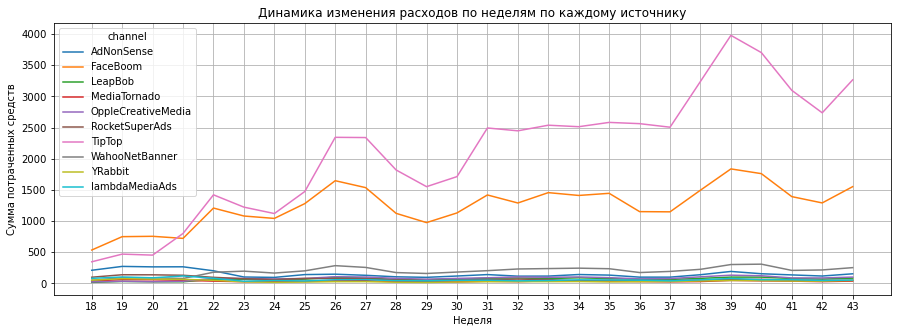

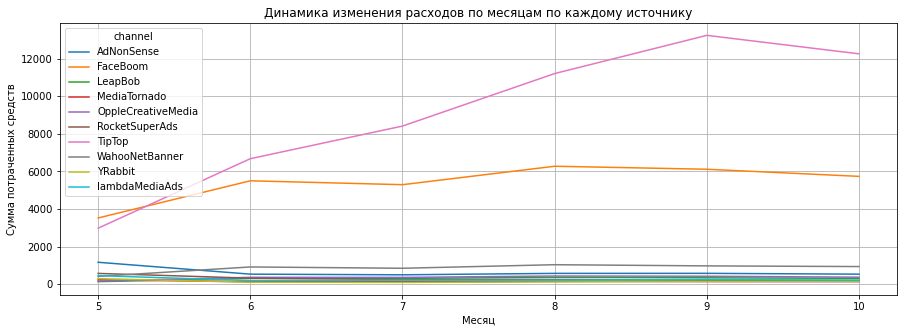

In [25]:
# график по неделям
ax1 = costs.pivot_table(
    index='channel', columns='week', values='costs', aggfunc='sum'
).T.plot(
    grid=True, figsize=(15,5), legend=True, xticks = tuple(costs['week'].unique())
).set(
    xlabel='Неделя', 
    ylabel='Сумма потраченных средств', 
    title='Динамика изменения расходов по неделям по каждому источнику'
)

# график по месяцам
ax2 = costs.pivot_table(
    index='channel', columns='month', values='costs', aggfunc='sum'
).T.plot(
    grid=True, figsize=(15,5), legend=True, xticks = tuple(costs['month'].unique())
).set(
    xlabel='Месяц', 
    ylabel='Сумма потраченных средств', 
    title='Динамика изменения расходов по месяцам по каждому источнику'
)

plt.show()

Выводы:

- Суммарные траты на источник `TipTop` по месяцам со временем постепенно росли. 
- Начиная с 21 недели средств на него стало тратиться больше, чем на `FaceBoom`. Начиная с 27 недели траты на `TipTop` примерно в 1.5 раза больше, чем на `FaceBoom`. А начиная с 36 недели примерно в 2 раза больше.
- Начиная с 6 месяца суммарные траты в месяц на `FaceBoom` были примерно одинаковыми.
- В динамике трат по неделям видится сезонность. В некоторые недели на эти источники средств тратилось больше, в некоторые месяцы меньше.
- Пик значений на 39 неделе. На `TipTop` было потрачено 4000, на `FaceBoom` примерно 1800.
- Пик значений на 9 месяце, что совпадает с недельными тратами. На `TipTop` было потрачено примерно 11 тысяч, на `FaceBoom` примерно 6000.
- На все остальные источники в течение всего периода тратилось примерно одинаковое количество средств, меньше 300 в неделю и меньше 1500 в месяц.

### Анализ средней стоимости привлечения пользователей <a id="cac">

Построим таблицу с рейтингом рекламных источников по средней стоимости привлечения пользователей (САС). А также дополнительно посчитаем САС всего приложения.

In [26]:
# игнорируем органических пользователей, тк они не нужны при расчете САС
# сортируем по убыванию, чтобы сформировать топ
# сбрасываем индексы, чтобы убрать вложенности заголовков столбцов
# добавляем закрашивание цветом для визуализации разницы
display(profiles.query('channel != "organic"').groupby('channel').agg({
    'acquisition_cost': 'mean'
}).sort_values(by='acquisition_cost', ascending=False).reset_index().style.background_gradient(cmap='BuGn'))

print('САС всего проекта: {}'.format(profiles['acquisition_cost'].mean()))

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


САС всего проекта: 0.7032778251827625


Вывод:

- Самая дорогая средняя стоимость привлечения пользователей у рекламного источника `TipTop`: около 2.8 за пользователя.
- Второй и третий источники по стоимости пользователя - `FaceBoom` и `AdNonSense`, где стоимость примерно 1.1 и 1 соответственно.
- CAC всего проекта равен 0.7. У остальных источников стоимость примерно равна этому показателю или ниже его.

## Оценка окупаемости рекламы <a id="roi">

### Анализ общей окупаемости рекламы <a id="roi_total">

Установим момент и горизонт анализа данных. Предположим, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее, чем через две недели после привлечения.

In [27]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Далее потребуется изучать профили пользователей, которые пришли только из рекламных источников. Удалим из анализа пользователей, пришедших из органики.

In [28]:
profiles = profiles.query('channel != "organic"')

Рассчитаем и визуализируем общий LTV и ROI.

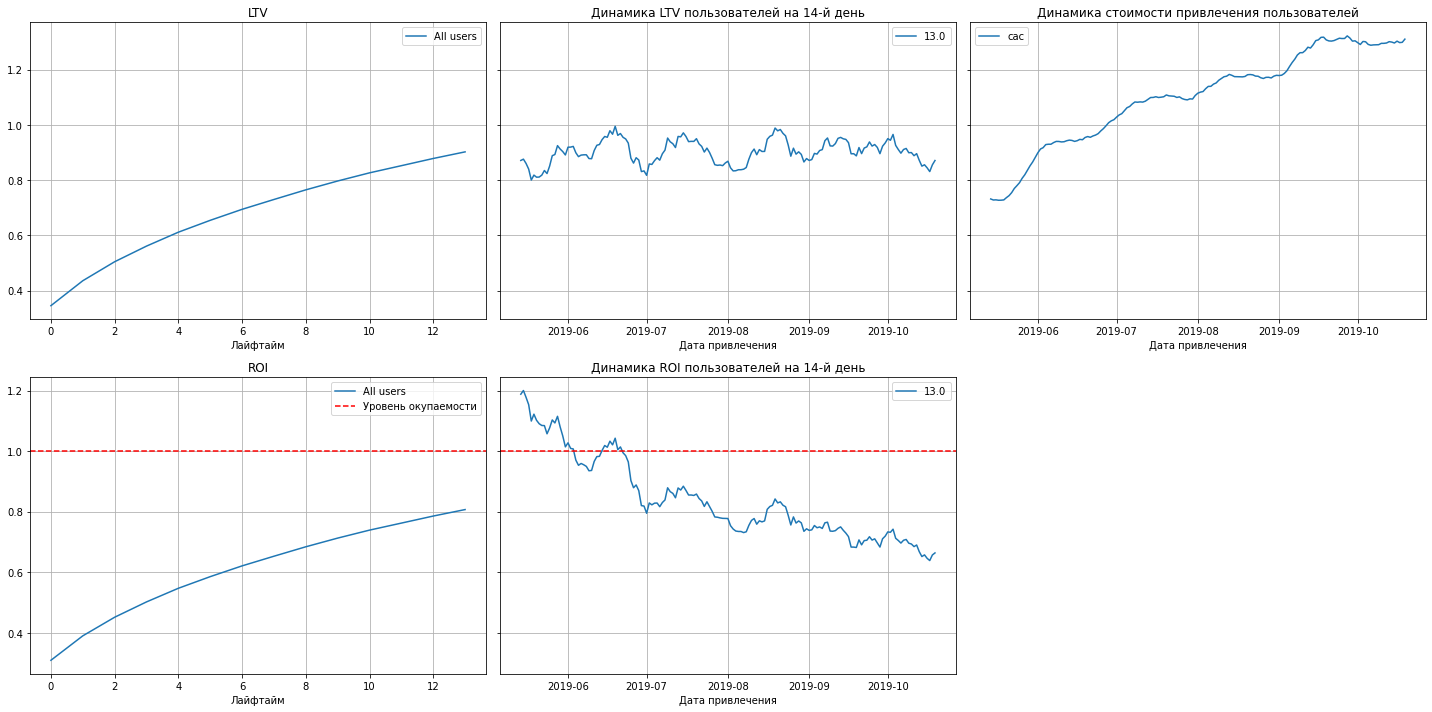

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Выводы: 

- LTV достаточно стабилен.
- Стоимость привлечения пользователей растет в конце почти каждого месяца.
- Реклама не окупается в течение 14 дней жизни пользователя в среднем за весь период. Около 81%.
- ROI 14-го в течение всего периода падает. До середины июня колеблется около 1, далее опускается ниже 1. 
- Рост САС и падение ROI может быть связано с постепенным увеличением расходов на источник `TipTop`.

### Анализ конверсии пользователей <a id="conversion">

Проверим общую конверсию пользователей и динамику её изменения. Построим их графики.

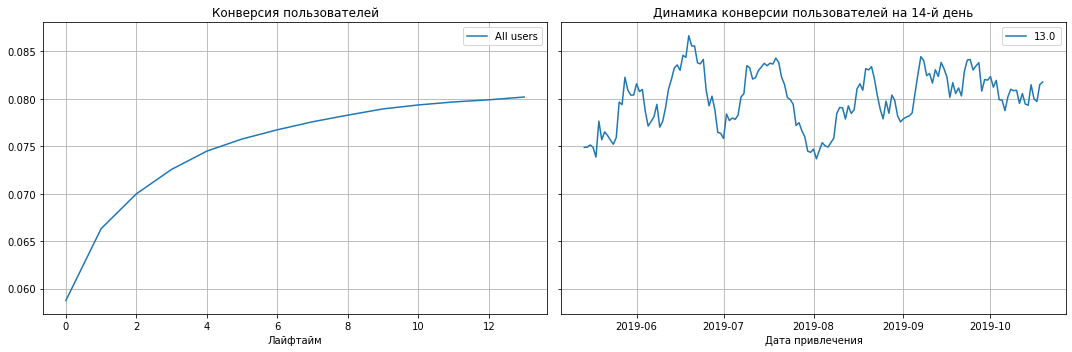

In [30]:
# получаем данные по конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Вывод:

- Конверсия пользователей экспоненциально растет к 14 дню. С ней все хорошо.
- В течение всего периода конверсия колеблется в диапазоне примерно от 0.074 до 0.086.

### Анализ удержания пользователей <a id="retention">

Проверим общее удержание пользователей и динамику его изменения. Построим их графики.

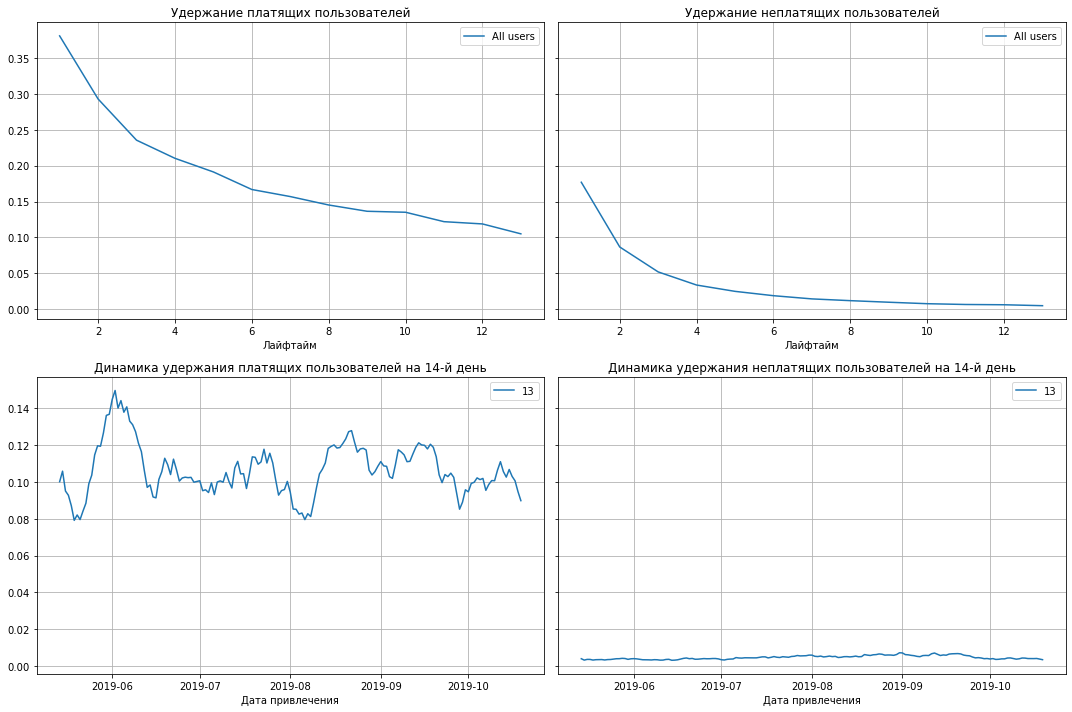

In [31]:
# считаем удержание
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_retention(retention, retention_history, horizon_days, window=14)

Вывод:

- Удержание платящих пользователей выше, чем у неплатящих. Тут все хорошо.
- Динамика удержания пользователей на 14-й день находится примерно на одном уровне. Для платящих варьируется в диапазоне от 0.08 до 0.15, для неплатящих около 0.005-0.01.

### Анализ окупаемости рекламы с разбивкой по устройствам <a id="roi_by_devices">

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

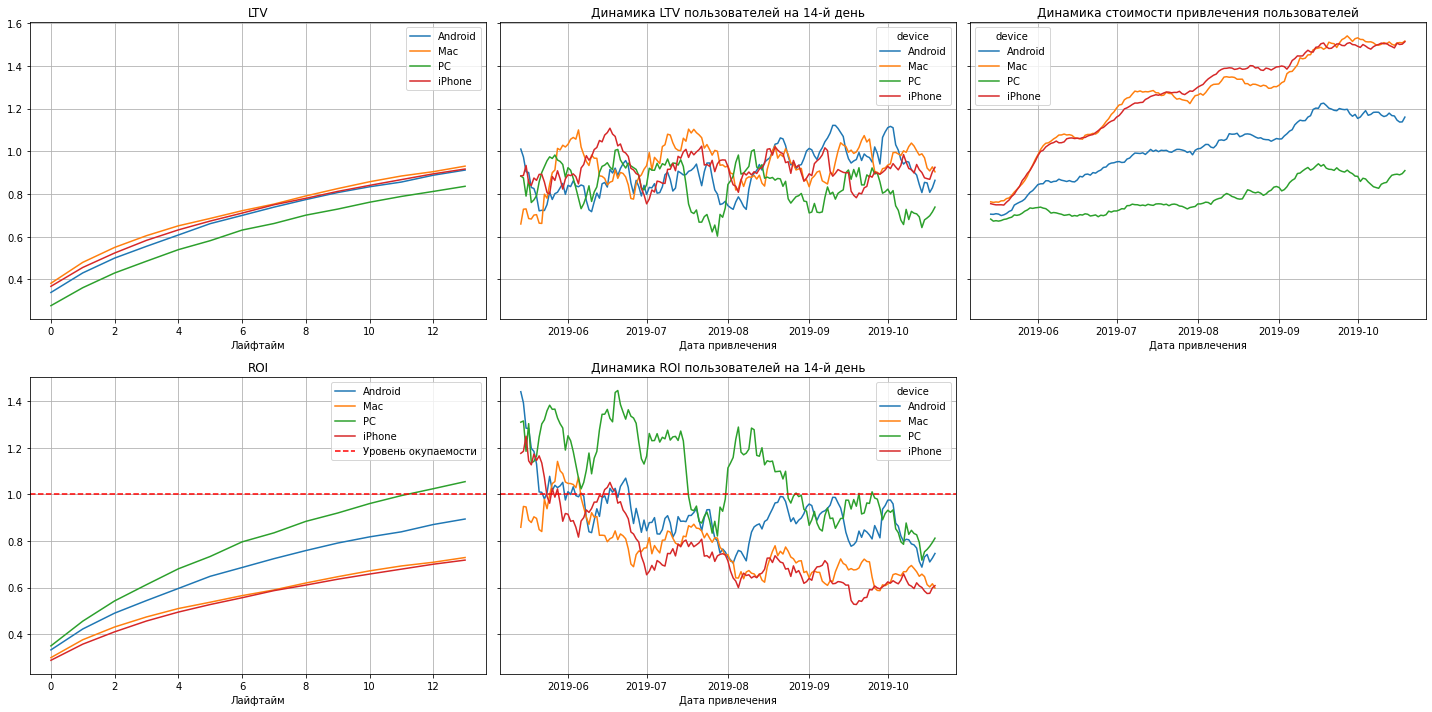

In [32]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Вывод:

- LTV постепенно растет со временем жизни пользователей. На всех устройствах показатели примерно одинаковые, кроме `PC` (на нем примерно на 0.1 ниже).
- Динамика LTV 14-го дня у всех платформ колеблется в примерно одинаковых диапазонах в течение всего периода.
- Стоимость привлечения пользователей на всех платформах в течение периода растет.
- На `iPhone` и `Mac` стоимость привлечения находится примерно на одном уровне, дороже всех остальных. Реклама на обеих платформах не окупается в течение 14 дней, в среднем за период ROI 70%. По динамике ROI 14-го дня до середины июня колеблется около 1, далее ниже 1.
- Средние показатели стоимости привлечения на `Android`. Реклама на нем также не окупается, в среднем за период жизни ROI 90%. По динамике ROI 14-го дня до середины июля колеблется около 1, далее ниже 1. В середине августа и сентября, а также в конце сентября приближался к 1, но все равно ниже него.
- Стоимость привлечения пользователей дешевле всех на `PC`. Реклама не нем окупается с 11 дня. По динамике ROI 14-го дня до середины июля выше 1, вторую половину июля меньше, до конца августа снова выше 1, далее до конца периода ниже 1, но в сентябре близко к ней.

Проверим конверсию пользователей в разбивке по устройствам и динамику её изменения. Построим их графики.

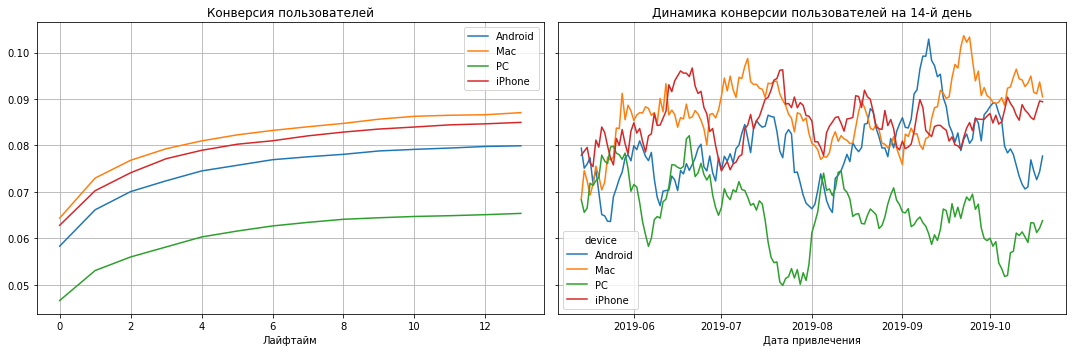

In [33]:
# получаем данные по конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Вывод: 

- Конверсия пользователей на большинстве платформ примерно одинаковая, кроме `PC`. На этой платформе примерно на четверть меньше, чем у остальных.
- В течение всего периода конверсия 14-го дня колеблется в общем диапазоне у большинства платформ, кроме `PC`. На ней заметно ниже.

Проверим удержание пользователей в разбивке по устройствам и динамику его изменения. Построим их графики.

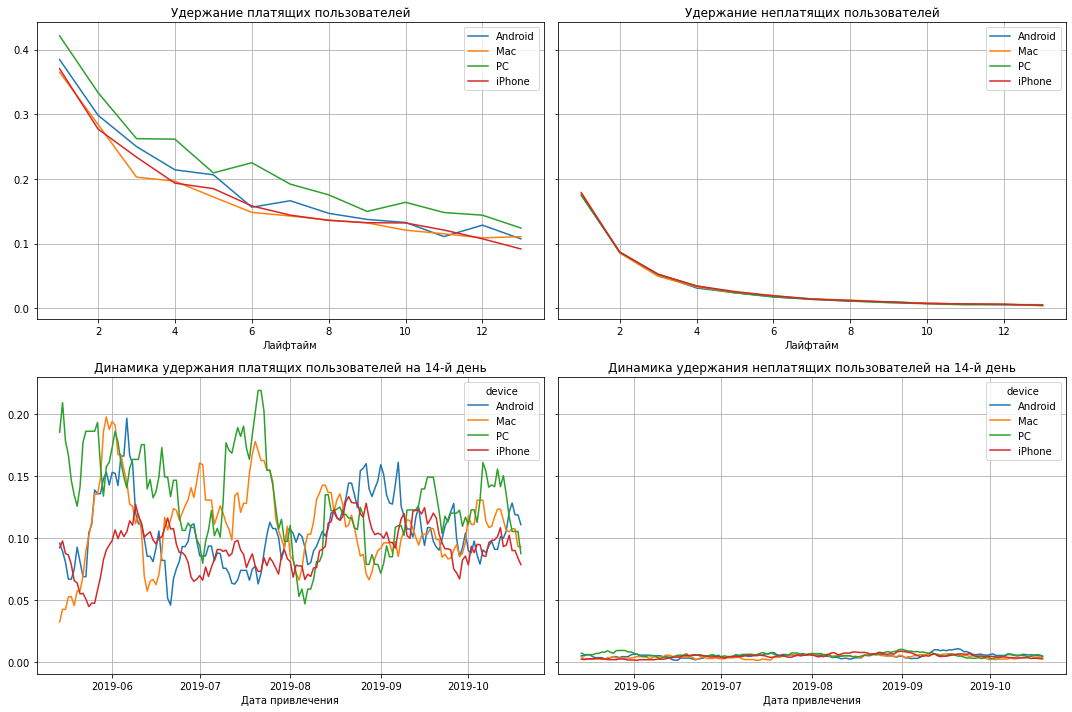

In [34]:
# считаем удержание
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_retention(retention, retention_history, horizon_days, window=14)

Вывод:

- Удержание платящих пользователей выше, чем у неплатящих. Показатели примерно одинаковые на всех платформах.
- Динамика удержания пользователей на 14-й день колеблется в общих диапазонах. 

### Анализ окупаемости рекламы с разбивкой по странам <a id="roi_by_countries">

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

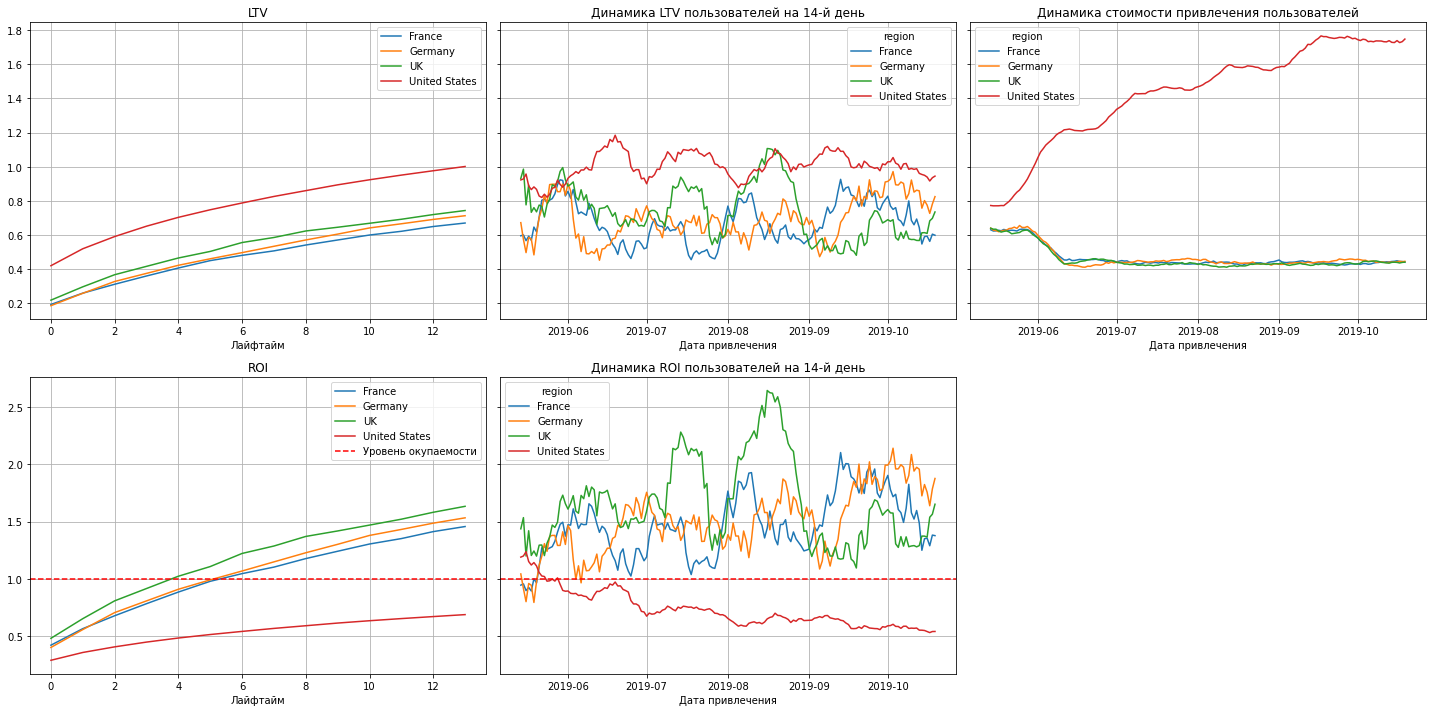

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Вывод:

- LTV постепенно растет со временем жизни пользователей. Во всех странах показатели примерно одинаковые, кроме США (здесь примерно на 0.3 выше). В динамике 14-го дня показатель у всех стран находится в общем диапазоне.
- Стоимость привлечения пользователей во всех странах примерно одинаковая, кроме США. Здесь растет в конце почти каждого месяца. В октябре стала в 4 раза дороже, чем в остальных странах.
- В остальных странах САС с июня стал на треть дешевле, и весь остальной период держится на одном уровне.
- В США реклама не окупается в течение 14 дней жизни пользователей, в среднем за весь период около 70%. В динамике ROI 14-го дня в течение всего периода падает, после июня становится ниже 1.
- В остальных странах реклама окупается с 4-5 дня. В динамике ROI 14-го дня имеет сезонные перепады, но в целом держится в общих диапазонах.

Проверим конверсию пользователей в разбивке по странам и динамику её изменения. Построим их графики.

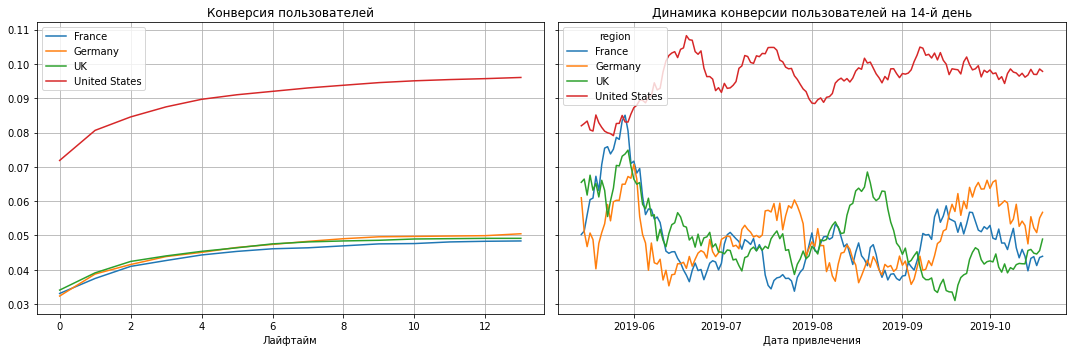

In [36]:
# получаем данные по конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Вывод:

- Конверсия пользователей в большинстве стран примерно одинаковая, кроме США. В этом регионе примерно в 2 раза больше, чем у остальных.
- В течение всего периода конверсия 14-го дня колеблется в общем диапазоне у большинства стран, кроме США. Здесь заметно выше.
- Высокая конверсия пользователей США объясняется самой высокой долей платящих пользователей в этом регионе.

Проверим удержание пользователей в разбивке по странам и динамику его изменения. Построим их графики.

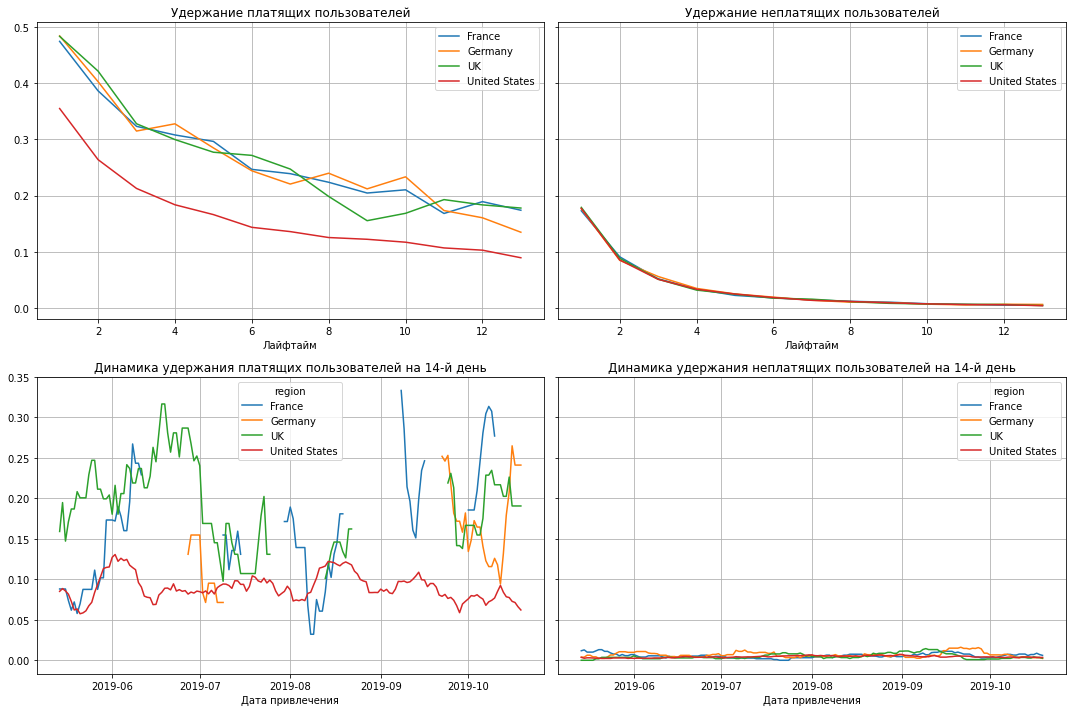

In [37]:
# считаем удержание
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_retention(retention, retention_history, horizon_days, window=14)

Вывод:

- Удержание платящих пользователей в большинстве стран примерно одинаковое, кроме США. Здесь пользователи удерживаются немного хуже, показатель примерно на 0.05-0.1 меньше, чем в остальных регионах.
- Динамика удержания 14-го дня у платящих пользователей в большинстве стран не очень стабильна. Это может быть связано с небольшим количеством новых пользователей в некоторые периоды. 
- Удержание неплатящих и ее динамика примерно одинаковые во всех странах.

### Анализ окупаемости рекламы с разбивкой по рекламным источникам <a id="roi_by_channels">

Проанализируем окупаемость рекламы с разбивкой по рекламным источникам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

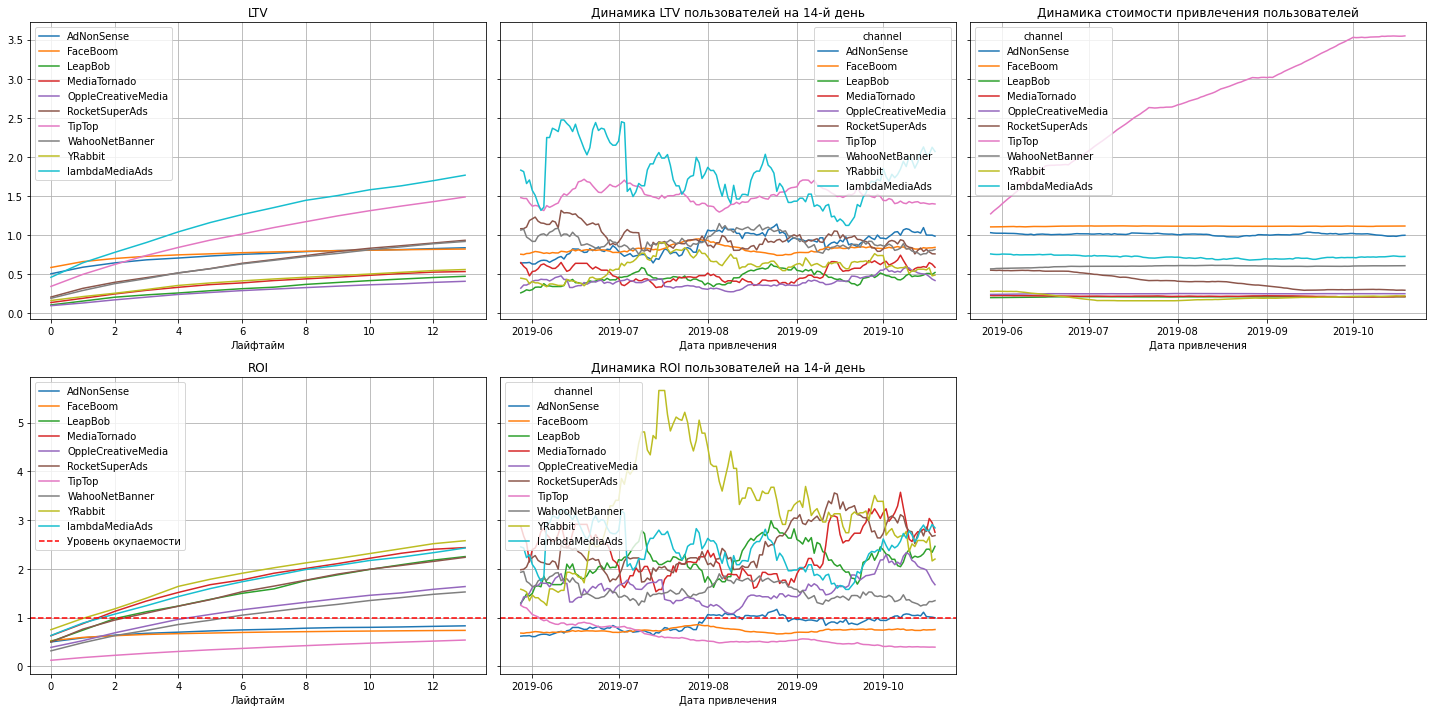

In [38]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики со скользящим средним в 4 недели, чтобы сгладить графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28) 

Выводы: 

- LTV в течение всего периода в большинства источников находится в общем диапазоне. У `TipTop` и `lambdaMediaAds` немного выше, чем у остальных (примерно на 1-1.5).
- Реклама на `AdNonSense`, `FaceBoom`, `TipTop` в течение 14 дней жизни пользователя не окупается. ROI примерно от 60 (у `TipTop`) до 80-90%. В динамике на `FaceBoom` и `TipTop` ROI 14-дня ниже 1 в течение практически всего периода. У `AdNonSense` начиная с августа колеблется около 1, до этого времени также был ниже.
- На всех остальных источниках реклама окупается, начиная с 1-6 дня. ROI 14-го дня у всех источников всегда больше 1.
- Стоимость привлечения пользователей у всех источников стабильна, кроме `TipTop`. На нем показатель постоянно растет. В октябре составляет чуть больше 3.5 за пользователя, что в 3-5 раз больше, чем у всех остальных.

Проверим конверсию пользователей в разбивке по рекламным источникам и динамику её изменения. Построим их графики.

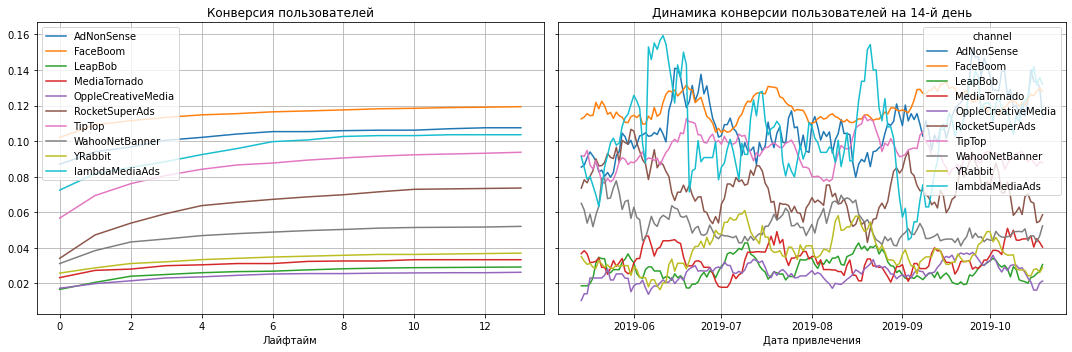

In [39]:
# получаем данные по конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Вывод:

- Самая высокая конверсия у `FaceBoom` (0.12 за весь период). Чуть ниже у `AdNonSense`, `lambdaMediaAds` и `TipTop` (0.11, 0.105 и 0.095 соответственно). У остальных источников меньше 0.08.
- Динамика конверсии имеет сезонные перепады, но в целом стабильная у всех источников.

Проверим удержание пользователей в разбивке по рекламным источникам и динамику его изменения. Построим их графики.

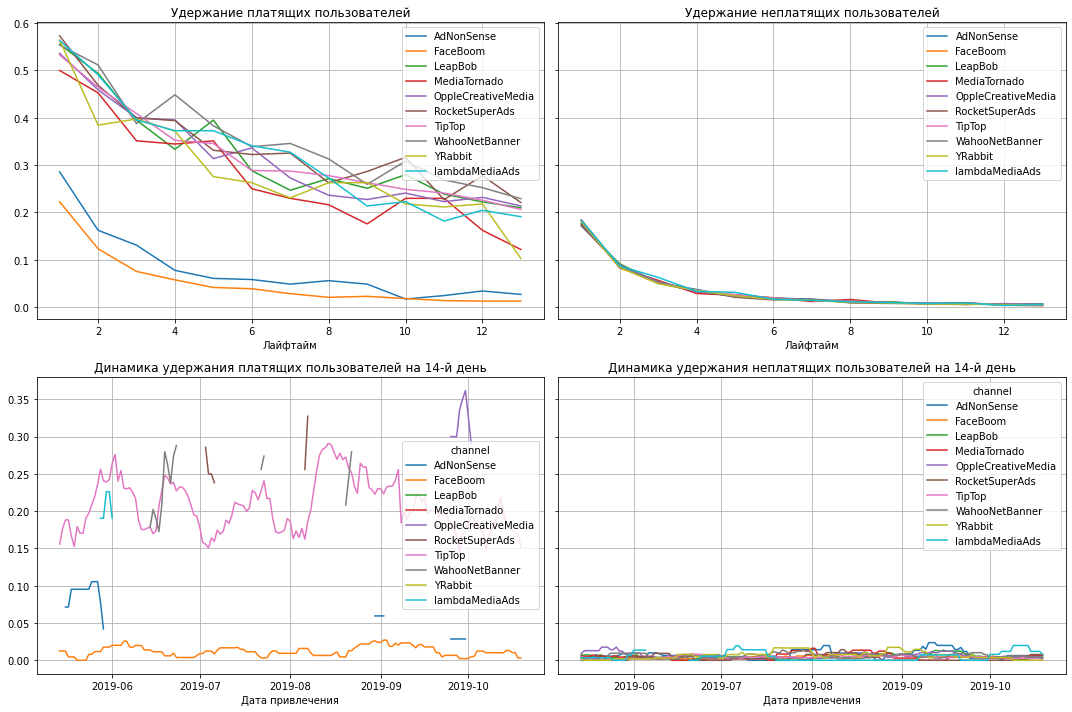

In [40]:
# считаем удержание
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

# строим графики со скользящим средним в 2 недели, чтобы сгладить графики
plot_retention(retention, retention_history, horizon_days, window=14)

Вывод:

- Удержание платящих пользователей в большинстве источников примерно одинаковое, кроме `FaceBoom` и `AdNonSense`. Здесь пользователи удерживаются на уровне неплатящих.
- Динамика удержания 14-го дня у платящих пользователей у большинства источников не очень стабильна. Это может быть связано с небольшим количеством новых пользователей в некоторые периоды.
- Удержание неплатящих и ее динамика примерно одинаковые у всех источников.

## Общий вывод <a id="total">

Анализ стран пользователей:

- Пользователи приходят в приложение из 4 стран: США, Великобритания, Франция и Германия.
- Больше всего пользователей из США. Больше всего платящих пользователей и самая большая их доля - также в США.
- В остальных странах показатели примерно одинаковые.

Анализ устройств пользователей:

- Пользователи приложения пользуются устройствами на 4 платформах: `iPhone`, `Android`, `PC`, `Mac`.
- Больше всего пользователей, в том числе и платящих, используют iPhone. Количество пользователей с другими устройствами примерно одинаковое.
- Самые большие доли платящих пользователей на `Mac` и `iPhone`. Чуть меньше на `Android`. Меньше всего на `PC`.

Анализ рекламных источников:

- Для привлечения пользователей было использовано 10 рекламных источников.
- Больше всего пользователей пришло в приложение из органики. При этом доля платящих среди них самая маленькая.
- Среди рекламных источников больше всего пользователей, в том числе и платящих, пришло из `FaceBoom`: 29.1 тысяч всего и 3557 платящих.
- Чуть меньше пришло из `TipTop`. Около 19.6 тысяч всего и 1878 платящих.
- Из других источников пришло меньше 8600 пользователей и 230 платящих на каждый источник.
- Самые большие доли платящих пользователей в источниках `FaceBoom`, `AdNonSense` и `lambdaMediaAds`, по 12.2%, 11.3% и 10.5% соответственно. Чуть меньше в `TipTop` - 9.6%. У всех остальных источников доли платящих меньше 8%.

Анализ маркетинга:

- Больше всего средств потратили на источник `TipTop` (около 51.9% от суммы всех расходов за период).
- Второй источник по количеству потраченных средств - `FaceBoom` (около 30.8% от общей суммы).
- Суммарные траты на источник `TipTop` по месяцам постепенно росли. Начиная с 36 недели разница примерно в 2 раза больше, чем на `FaceBoom`.
- На все остальные источники в течение всего периода тратилось примерно одинаковое количество средств.
- Самая дорогая средняя стоимость привлечения пользователей у рекламного источника `TipTop`: около 2.8 за пользователя.
- Второй и третий источники по стоимости пользователя - `FaceBoom` и `AdNonSense`, где стоимость примерно 1.1 и 1 соответственно.
- CAC всего проекта равен 0.7. У остальных источников стоимость примерно равна этому показателю или ниже его.

Анализ общей окупаемости рекламы, конверсии и удержания пользователей:

- LTV достаточно стабилен.
- Стоимость привлечения пользователей растет в конце почти каждого месяца.
- Реклама не окупается в течение 14 дней жизни пользователя в среднем за весь период. Около 81%. ROI 14-го в течение всего периода падает. До середины июня колеблется около 1, далее опускается ниже 1. 
- Конверсия пользователей экспоненциально растет к 14 дню. В течение всего периода конверсия колеблется в одном диапазоне. С ней все хорошо.
- Удержание платящих пользователей выше, чем у неплатящих. Динамика удержания пользователей на 14-й день находится примерно на одном уровне. Тут все хорошо.

Анализ окупаемости с разбивкой по устройствам:

- LTV постепенно растет со временем жизни пользователей. На всех устройствах показатели примерно одинаковые, кроме PC (на нем примерно на 0.1 ниже). Динамика LTV 14-го дня у всех платформ колеблется в примерно одинаковых диапазонах в течение всего периода.
- Стоимость привлечения пользователей на всех платформах в течение периода растет.
- На `iPhone` и `Mac` стоимость привлечения находится примерно на одном уровне, дороже всех остальных. Реклама на обеих платформах не окупается в течение 14 дней, в среднем за период ROI 70%. По динамике ROI 14-го дня до середины июня колеблется около 1, далее ниже 1.
- Средние показатели стоимости привлечения на `Android`. Реклама на нем также не окупается, в среднем за период жизни ROI 90%. По динамике ROI 14-го дня до середины июля колеблется около 1, далее ниже 1.
- Стоимость привлечения пользователей дешевле всех на `PC`. Реклама не нем окупается с 11 дня. По динамике ROI 14-го дня до середины июля выше 1, далее колеблется около +-1.
- Конверсия пользователей на большинстве платформ примерно одинаковая, кроме `PC`. На этой платформе примерно на четверть меньше. В течение всего периода конверсия 14-го дня колеблется в общем диапазоне у большинства платформ, кроме `PC`. На ней заметно ниже.
- Удержание платящих пользователей выше, чем у неплатящих. Показатели примерно одинаковые на всех платформах. Динамика удержания пользователей на 14-й день колеблется в общих диапазонах.

Анализ окупаемости с разбивкой по странам:

- LTV постепенно растет со временем жизни пользователей. Во всех странах показатели примерно одинаковые, кроме США (здесь примерно на 0.3 выше). В динамике 14-го дня показатель у всех стран находится в общем диапазоне.
- Стоимость привлечения пользователей во всех странах примерно одинаковая, кроме США. Здесь растет в конце почти каждого месяца. В октябре стала в 4 раза дороже, чем в остальных странах. В остальных странах САС с июня стал на треть дешевле, и весь остальной период держится на одном уровне.
- В США реклама не окупается в течение 14 дней жизни пользователей, в среднем за весь период около 70%. В динамике ROI 14-го дня в течение всего периода падает, после июня становится ниже 1.
- В остальных странах реклама окупается с 4-5 дня. В динамике ROI 14-го дня держится в общих диапазонах.
- Конверсия пользователей в большинстве стран примерно одинаковая, кроме США. В этом регионе примерно в 2 раза больше, чем у остальных. В течение всего периода конверсия 14-го дня колеблется в общем диапазоне у большинства стран, кроме США. Здесь заметно выше.
- Удержание платящих пользователей в большинстве стран примерно одинаковое, кроме США. Здесь пользователи удерживаются немного хуже, показатель примерно на 0.05-0.1 меньше, чем в остальных регионах. 
- Удержание неплатящих и ее динамика примерно одинаковые во всех странах.

Анализ окупаемости с разбивкой по рекламным источникам:

- LTV в течение всего периода в большинстве источников находится в общем диапазоне. У `TipTop` и `lambdaMediaAds` немного выше, чем у остальных.
- Реклама на `AdNonSense`, `FaceBoom`, `TipTop` в течение 14 дней жизни пользователя не окупается. ROI примерно от 60% (у `TipTop`) до 80-90%. В динамике на `FaceBoom` и `TipTop` ROI 14-дня ниже 1 в течение практически всего периода. У `AdNonSense` начиная с августа колеблется около 1, до этого времени также был ниже.
- На всех остальных источниках реклама окупается, начиная с 1-6 дня. ROI 14-го дня у всех источников всегда больше 1.
- Стоимость привлечения пользователей у всех источников стабильна, кроме `TipTop`. На нем показатель постоянно растет. В октябре в 3-5 раз больше, чем у всех остальных.
- Самая высокая конверсия у `FaceBoom` (0.12 за весь период). Чуть ниже у `AdNonSense`, `lambdaMediaAds` и `TipTop` (0.11, 0.105 и 0.095 соответственно). У остальных источников меньше 0.08. Динамика конверсии в целом стабильная у всех источников.
- Удержание платящих пользователей в большинстве источников примерно одинаковое, кроме `FaceBoom` и `AdNonSense`. Здесь пользователи удерживаются на уровне неплатящих.
- Удержание неплатящих и ее динамика примерно одинаковые у всех источников.

## Проблемы и рекомендации для бизнеса <a id="recommendations">

Основные проблемы:

1. САС на `iPhone`, `Mac` и `Android` кратно вырос за весь период. Особенно на `iPhone` и `Mac`.
2. САС в США кратно вырос за весь период.
3. Удержание в США хуже остальных регионов.
4. САС на `TipTop` кратно вырос за весь период. 
5. Низкое удержание платящих пользователей, пришедших из `FaceBoom` и `AdNonSense`.

Рекомендации:

- Стоит обратить внимание на закупку пользователей на `iPhone`, `Mac` и `Android`. Проанализировать период после середины июня-июля. Стоимость привлечения пользователей на этих платформах кратно выросла, и реклама перестала окупаться. С конверсией и удержанием все хорошо.
- Стоит обратить внимание на закупку пользователей в США, проанализировать период после начала июня. Почему стоимость привлечения пользователей в этой стране кратно выросла? Динамика падения окупаемости примерно совпадает с динамикой у пользователей с `iPhone` и `Mac`. Нет ли тут общей проблемы? Пользователи в этом регионе удерживаются хуже остальных. Возможно, в приложении присутствует не очень популярный для этого региона контент.
- Стоит обратить внимание на рекламный источник `TipTop`. Почему расходы по нему кратно увеличились? График увеличения САС на нем совпадает с динамикой роста в США. Нет ли тут общей проблемы? Возможно, стоит уменьшить закупки на этой платформе, тем более, что например, `FaceBoom` обходится компании дешевле, и приносит больше платящих пользователей.
- Также стоит обратить внимание на `FaceBoom` и `AdNonSense`. Реклама на них тоже не окупается. Возможно, связано с удержанием пользователей из этих источников. Удержание платящих здесь практически такое же, как не платящих. Должно быть кратно больше. Возможно, реклама, показываемая в этих источниках, не совпадает с ожиданиями пользователей от приложения. Или реклама показывается не подходящим категориям пользователей под приложение.
- Полезно обратить внимание на источник `lambdaMediaAds`. У этого источника одни из самых высоких показателей окупаемости, одна из самых высоких конверсий, а также самый высокий LTV. Удержание на уровне большинства источников. Возможно, стоит увеличить расходы на этот источник, так как его показатели высокие, относительно остальных.
- Также из перспективных каналов можно подсветить `MediaTornado` и `RocketSuperAds`. 